In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import re
import numpy as np
import os
import io
import time

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:2', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:3', device_type='XLA_GPU')]

In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [6]:
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[2], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(logical_gpus)
    except Exception as e:
        print(e)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [7]:
path_to_zip = tf.keras.utils.get_file("/data/rrjin/corpus_data/spa-eng.zip", origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip", extract=True)

2646016/2638744 [==============================] - 1s 0us/step


In [8]:
path_to_zip

'/data/rrjin/corpus_data/spa-eng.zip'

In [29]:
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

In [30]:
path_to_file

'/data/rrjin/corpus_data/spa-eng/spa.txt'

In [31]:
def unicode_to_ascii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

In [32]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [33]:
en_sentence = u"May I borrow this book?"

In [34]:
print(preprocess_sentence(en_sentence))

<start> may i borrow this book ? <end>


In [35]:
sp_sentence = u"¿Puedo tomar prestado este libro?"

In [36]:
print(preprocess_sentence(sp_sentence))

<start> ¿ puedo tomar prestado este libro ? <end>


In [37]:
print(preprocess_sentence(sp_sentence).encode("utf-8"))

b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [40]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding="utf-8").read().strip().split("\n")
    word_pairs = [[preprocess_sentence(w) for w in l.split("\t")] for l in lines[:num_examples]]
    return zip(*word_pairs) # src, tgt

In [41]:
create_dataset(path_to_file, None)

In [42]:
en, sp = create_dataset(path_to_file, None)

In [166]:
sp[1]

'<start> vete . <end>'

In [44]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [45]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post")
    return tensor, lang_tokenizer

In [78]:
def load_dataset(path, num_examples=None):
    tgt_lang, src_lang = create_dataset(path, num_examples)
    
    src_tensor, src_lang_tokenizer = tokenize(src_lang)
    tgt_tensor, tgt_lang_tokenizer = tokenize(tgt_lang)
    
    return src_tensor, tgt_tensor, src_lang_tokenizer, tgt_lang_tokenizer

In [79]:
num_examples = 30000
src_tensor, tgt_tensor, src_lang_tokenizer, tgt_lang_tokenizer = load_dataset(path_to_file, num_examples)

In [189]:
max_length_src, max_length_tgt = max_length(src_tensor), max_length(tgt_tensor)

In [81]:
src_tensor_train, src_tensor_val, tgt_tensor_train, tgt_tensor_val = train_test_split(src_tensor, tgt_tensor, test_size=0.2)

In [82]:
print(len(src_tensor_train), len(src_tensor_val), len(tgt_tensor_train), len(tgt_tensor_val))

24000 6000 24000 6000


In [83]:
buffer_size = len(src_tensor_train)

In [84]:
batch_size = 64

In [85]:
steps_per_epoch = len(src_tensor_train) // batch_size

In [86]:
embedding_dim = 256

In [87]:
units = 1024

In [90]:
src_vocab_size = len(src_lang_tokenizer.word_index) + 1

In [91]:
tgt_vocab_size = len(tgt_lang_tokenizer.word_index) + 1

In [94]:
src_tensor.shape

(30000, 16)

In [96]:
dataset = tf.data.Dataset.from_tensor_slices((src_tensor_train, tgt_tensor_train)).shuffle(buffer_size)

In [97]:
dataset = dataset.batch(batch_size, drop_remainder=True)

In [154]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # input is :(batch_size, timesteps, input_dim)
        # if return_sequence is true: output is: (batch_size, timesteps, units)
        # else output is: (batch_size, units)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")
    
    def call(self, x, hidden):
        """
        Args:
            x: 2D tensor with shape: (batch_size, input_length)
            output_shape of x: 3D tensor with shape: (batch_size, input_length, embedding_dim)
        """
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [155]:
example_src_batch, example_tgt_batch = next(iter(dataset))

In [156]:
example_src_batch.shape, example_tgt_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [157]:
encoder = Encoder(src_vocab_size, embedding_dim, units, batch_size)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_src_batch, sample_hidden)
print("Encoder output shape :(batch_size, input_length, units) {}".format(sample_output.shape))
print("Encoder hidden shape :(batch_size units) {}".format(sample_hidden.shape))

Encoder output shape :(batch_size, input_length, units) (64, 16, 1024)
Encoder hidden shape :(batch_size units) (64, 1024)


In [158]:
dataset

<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>

In [159]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    
    def call(self, hs, ht):
        
        """
        Args:
            ht: (batch, input_length, units_of_encoder) output sequence
            hs: (batch, units_of_encoder) last hidden states
        """
        hs = tf.expand_dims(hs, axis=1)  # (batch, 1, units_of_encoder)
        
        # (batch, input_length, 1)
        score = self.V(tf.nn.tanh(self.W1(ht) + self.W2(hs)))  # broadcasting will hapen
        
        # (batch, input_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector (batch, input_length, units_of_encoder)
        context_vector = attention_weights * ht # broadcasting will hapen
        
        # context_vecor (batch, units_of_encoder)
        context_vector = tf.math.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [160]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape:(batch, units_of_encoder) {}".format(attention_result.shape))
print("Attention weight shape:(batch, input_length, 1) {}".format(attention_weights.shape))

Attention result shape:(batch, units_of_encoder) (64, 1024)
Attention weight shape:(batch, input_length, 1) (64, 16, 1)


In [161]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")
        
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
        
        
    def call(self, x, hidden, enc_output):
        
        """
        Args:
            x: (batch_size, 1)
        """
        
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # (batch_size, 1, units_of_encoder + embedding_dim)
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)
        
        # output: (batch_size, 1, dec_units)
        # state: (batch_size, dec_units)
        output, state = self.gru(x)
        
        output = tf.reshape(output, [-1, output.shape[2]])
        
        # (batch_size, vocab)
        x = self.fc(output)
        return x, state, attention_weights

In [162]:
decoder = Decoder(tgt_vocab_size, embedding_dim, units, batch_size)
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)
print("Decoder output shape (bathch_size, vocab) {}".format(sample_decoder_output.shape))

Decoder output shape (bathch_size, vocab) (64, 4935)


In [163]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [164]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [165]:
checkpoint_dir = "./training_check_points"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

In [177]:
@tf.function
def train_step(src, tgt, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        
        enc_output, enc_hidden = encoder(src, enc_hidden)
        
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index["<start>"]] * batch_size, axis=1)
        
        for t in range(1, tgt.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(tgt[:, t], predictions)
            
            # teacher forcing
            dec_input = tf.expand_dims(tgt[:, t], axis=1)
    
    batch_loss = (loss / tgt.shape[1])
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [179]:
for i, (x, y) in enumerate(dataset.as_numpy_iterator()):
    print(i, x.shape, y.shape)
    if i == 50:
        break

0 (64, 16) (64, 11)
1 (64, 16) (64, 11)
2 (64, 16) (64, 11)
3 (64, 16) (64, 11)
4 (64, 16) (64, 11)
5 (64, 16) (64, 11)
6 (64, 16) (64, 11)
7 (64, 16) (64, 11)
8 (64, 16) (64, 11)
9 (64, 16) (64, 11)
10 (64, 16) (64, 11)
11 (64, 16) (64, 11)
12 (64, 16) (64, 11)
13 (64, 16) (64, 11)
14 (64, 16) (64, 11)
15 (64, 16) (64, 11)
16 (64, 16) (64, 11)
17 (64, 16) (64, 11)
18 (64, 16) (64, 11)
19 (64, 16) (64, 11)
20 (64, 16) (64, 11)
21 (64, 16) (64, 11)
22 (64, 16) (64, 11)
23 (64, 16) (64, 11)
24 (64, 16) (64, 11)
25 (64, 16) (64, 11)
26 (64, 16) (64, 11)
27 (64, 16) (64, 11)
28 (64, 16) (64, 11)
29 (64, 16) (64, 11)
30 (64, 16) (64, 11)
31 (64, 16) (64, 11)
32 (64, 16) (64, 11)
33 (64, 16) (64, 11)
34 (64, 16) (64, 11)
35 (64, 16) (64, 11)
36 (64, 16) (64, 11)
37 (64, 16) (64, 11)
38 (64, 16) (64, 11)
39 (64, 16) (64, 11)
40 (64, 16) (64, 11)
41 (64, 16) (64, 11)
42 (64, 16) (64, 11)
43 (64, 16) (64, 11)
44 (64, 16) (64, 11)
45 (64, 16) (64, 11)
46 (64, 16) (64, 11)
47 (64, 16) (64, 11)
48

In [180]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 10
    
    for batch, (src, tgt) in enumerate(dataset.as_numpy_iterator()):
        batch_loss = train_step(src, tgt, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f}".format(epoch, batch, batch_loss.numpy()))
    
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print("Time taken for 1 epoch {} sec \n".format(time.time() - start))

Epoch 0 Batch 0 Loss 4.6630
Epoch 0 Batch 100 Loss 2.1399
Epoch 0 Batch 200 Loss 1.8757
Epoch 0 Batch 300 Loss 1.7250
Time taken for 1 epoch 40.050865650177 sec 

Epoch 1 Batch 0 Loss 1.5574
Epoch 1 Batch 100 Loss 1.3636
Epoch 1 Batch 200 Loss 1.4104
Epoch 1 Batch 300 Loss 1.2972
Time taken for 1 epoch 31.20362663269043 sec 

Epoch 2 Batch 0 Loss 1.0315
Epoch 2 Batch 100 Loss 1.0685
Epoch 2 Batch 200 Loss 1.0386
Epoch 2 Batch 300 Loss 0.9027
Time taken for 1 epoch 30.90855097770691 sec 

Epoch 3 Batch 0 Loss 0.7472
Epoch 3 Batch 100 Loss 0.6549
Epoch 3 Batch 200 Loss 0.7085
Epoch 3 Batch 300 Loss 0.6825
Time taken for 1 epoch 31.21520733833313 sec 

Epoch 4 Batch 0 Loss 0.4659
Epoch 4 Batch 100 Loss 0.3772
Epoch 4 Batch 200 Loss 0.4765
Epoch 4 Batch 300 Loss 0.4158
Time taken for 1 epoch 30.909621477127075 sec 

Epoch 5 Batch 0 Loss 0.3094
Epoch 5 Batch 100 Loss 0.3266
Epoch 5 Batch 200 Loss 0.3426
Epoch 5 Batch 300 Loss 0.3026
Time taken for 1 epoch 31.094359636306763 sec 

Epoch 6 Ba

In [183]:
type(src_lang_tokenizer.word_index)

dict

In [243]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_tgt, max_length_src))
    sentence = preprocess_sentence(sentence)
    
    input_tensor = [src_lang_tokenizer.word_index.get(word, 0) for word in sentence.split()]
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences([input_tensor], maxlen=max_length_src, padding="post")
    
    input_tensor = tf.convert_to_tensor(input_tensor)
    
    result = ""
    
    hidden = tf.zeros((1, units))
    enc_out, enc_hidden = encoder(input_tensor, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index["<start>"]], 0)
    
    for t in range(max_length_tgt):
        
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
#         print(predicted_id)
        
        result += tgt_lang_tokenizer.index_word[predicted_id] + " "
#         print(result)
        
        if tgt_lang_tokenizer.index_word[predicted_id] == "<end>":
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
#         print(dec_input.shape)
        
    return result, sentence, attention_plot

In [247]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap="viridis")
    
    fontdict = {"fontsize":14}
    
    ax.set_xticklabels([""]+sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([""]+predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [248]:
def translate(sentence):
    
    result, sentence, attention_plot = evaluate(sentence)
    
    print("Input: {}".format(sentence))
    print("Predicted translation: {}".format(result))
    
    attention_plot = attention_plot[:len(result.split()), :len(sentence.split())]
    plot_attention(attention_plot, sentence.split(), result.split())

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


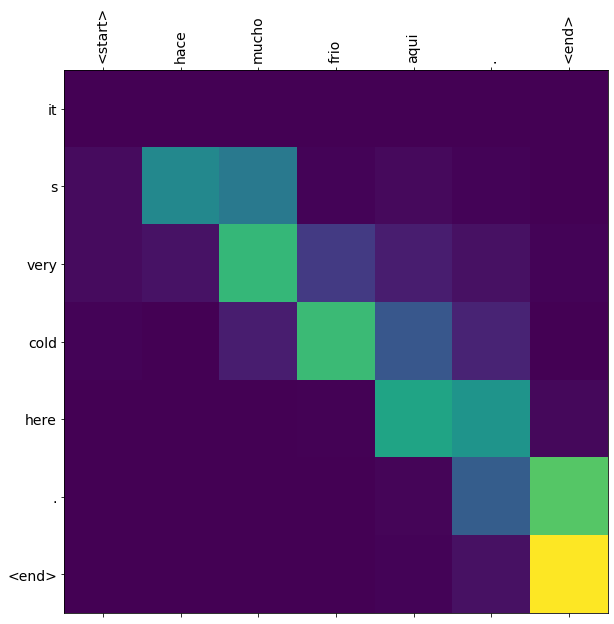

In [249]:
translate(u'hace mucho frio aqui.')